In [1]:
pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.8 MB/s eta 0:00:00:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor


s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-1/train.csv'
file_key_2 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-1/test.csv'
file_key_3 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-1/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
test = pd.read_csv(file_content_stream_2)
submission = pd.read_csv(file_content_stream_3)

In [5]:
train.describe()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,37137.00000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000
mean,18568.00000,3.851029,26.057005,5.163124,1.062204,1660.778919,2.831243,35.570030,-119.554329,2.079751
std,10720.67281,1.803167,12.158221,1.206242,0.096490,1302.469608,2.702413,2.083179,1.974028,1.158571
min,0.00000,0.499900,2.000000,0.851064,0.500000,3.000000,0.950000,32.550000,-124.350000,0.149990
25%,9284.00000,2.602300,17.000000,4.357522,1.020305,952.000000,2.394495,33.930000,-121.800000,1.208000
50%,18568.00000,3.515600,25.000000,5.068611,1.054545,1383.000000,2.744828,34.190000,-118.450000,1.808000
75%,27852.00000,4.699700,35.000000,5.858597,1.088825,1856.000000,3.125313,37.700000,-118.020000,2.660000
max,37136.00000,15.000100,52.000000,28.837607,5.873181,35682.000000,502.990610,41.950000,-114.550000,5.000010


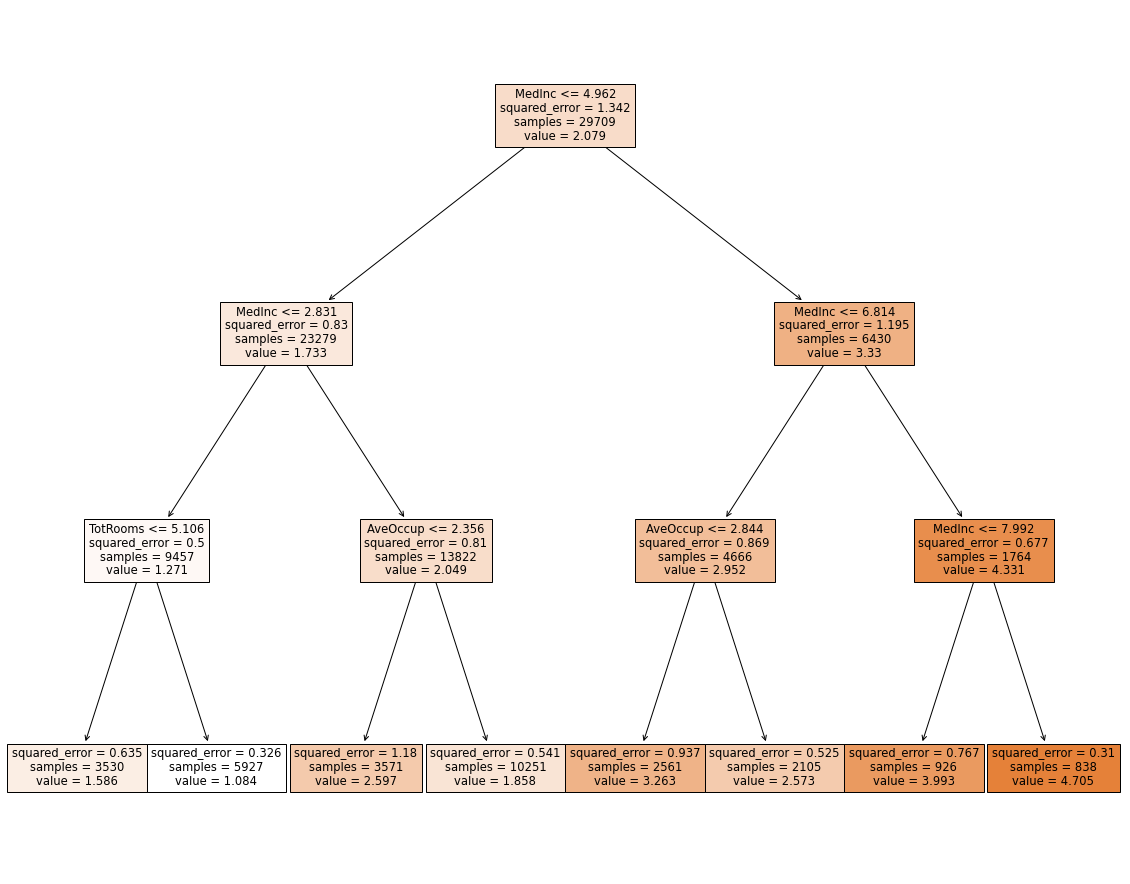

In [31]:
## Defining the input and target variables
X = train.drop(columns = ['id', 'MedHouseVal'], axis = 1)
Y = train['MedHouseVal']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True)

## Building a decision tree model with max depth = 3 on the train data-frame
tree_md = DecisionTreeRegressor(max_depth = 3).fit(X_train, Y_train)

## Visualizing the decision tree model and identify any interesting interactions/features
fig = plt.figure(figsize = (20, 16))
plot_tree(tree_md, feature_names = X.columns, filled = True);

In [27]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12
1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22
2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45
3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09
4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41


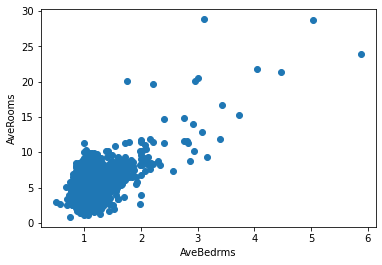

In [13]:
plt.plot(train['AveBedrms'], train['AveRooms'], 'o')
plt.xlabel('AveBedrms')
plt.ylabel('AveRooms')
plt.show();

In [15]:
sum(train['AveBedrms'] < train['AveRooms'])

37137

In [19]:
train['TotRooms'] = train['AveBedrms'] + train['AveRooms']
train['ratio'] = train['AveBedrms'] / train['AveRooms']
train.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,feature_1,feature_2,feature_3,ratio,TotRooms
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980,0,1,0,0.290581,4.939260
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946,0,1,0,0.175312,7.067590
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576,0,1,0,0.168795,7.638778
3,3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336,0,1,0,0.288171,4.315636
4,4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500,0,1,0,0.249567,5.353650


In [20]:
train.describe()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,feature_1,feature_2,feature_3,ratio,TotRooms
count,37137.00000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000,37137.000000
mean,18568.00000,3.851029,26.057005,5.163124,1.062204,1660.778919,2.831243,35.570030,-119.554329,2.079751,0.027924,0.786870,0.233487,0.217126,6.225328
std,10720.67281,1.803167,12.158221,1.206242,0.096490,1302.469608,2.702413,2.083179,1.974028,1.158571,0.164756,0.409524,0.423055,0.056665,1.226788
min,0.00000,0.499900,2.000000,0.851064,0.500000,3.000000,0.950000,32.550000,-124.350000,0.149990,0.000000,0.000000,0.000000,0.087521,1.601064
25%,9284.00000,2.602300,17.000000,4.357522,1.020305,952.000000,2.394495,33.930000,-121.800000,1.208000,0.000000,1.000000,0.000000,0.178862,5.414548
50%,18568.00000,3.515600,25.000000,5.068611,1.054545,1383.000000,2.744828,34.190000,-118.450000,1.808000,0.000000,1.000000,0.000000,0.208421,6.123358
75%,27852.00000,4.699700,35.000000,5.858597,1.088825,1856.000000,3.125313,37.700000,-118.020000,2.660000,0.000000,1.000000,0.000000,0.245440,6.926110
max,37136.00000,15.000100,52.000000,28.837607,5.873181,35682.000000,502.990610,41.950000,-114.550000,5.000010,1.000000,1.000000,1.000000,0.950893,33.791857


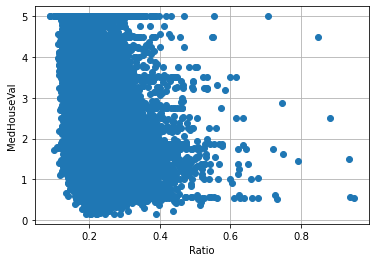

In [18]:
plt.plot(train['ratio'], train['MedHouseVal'], 'o')
plt.xlabel('Ratio')
plt.ylabel('MedHouseVal')
plt.grid()
plt.show();

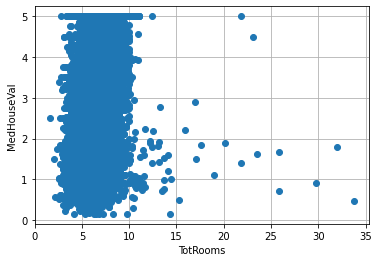

In [22]:
plt.plot(train['TotRooms'], train['MedHouseVal'], 'o')
plt.xlabel('TotRooms')
plt.ylabel('MedHouseVal')
plt.grid()
plt.show();

In [42]:
train['feature_1'] = np.where(train['MedInc'] >= 8, 1, 0)
train['feature_2'] = np.where(train['MedInc'] <= 5, 1, 0)
train['feature_3'] = np.where((train['MedInc'] <= 3) & (train['AveRooms'] >= 4), 1, 0)
# train['feature_4'] = np.where((train['MedInc'] > 5) & (train['MedInc'] <= 6.8) & (train['AveOccup'] >= 2.8), 1, 0)
# train['feature_5'] = train['AveBedrms'] + train['AveRooms']
# train['feature_6'] = train['AveBedrms'] / train['AveRooms']

test['feature_1'] = np.where(test['MedInc'] >= 8, 1, 0)
test['feature_2'] = np.where(test['MedInc'] <= 5, 1, 0)
test['feature_3'] = np.where((test['MedInc'] <= 3) & (test['AveRooms'] >= 4), 1, 0)
# test['feature_4'] = np.where((test['MedInc'] > 5) & (test['MedInc'] <= 6.8) & (test['AveOccup'] >= 2.8), 1, 0)
# test['feature_5'] = test['AveBedrms'] + test['AveRooms']
# test['feature_6'] = test['AveBedrms'] / test['AveRooms']

In [36]:
train.head()

,id,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6
0,0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980,0,1,0,0,4.939260,0.290581
1,1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946,0,1,0,0,7.067590,0.175312
2,2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576,0,1,0,0,7.638778,0.168795
3,3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336,0,1,0,0,4.315636,0.288171
4,4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500,0,1,0,0,5.353650,0.249567


100%|██████████| 50/50 [01:35<00:00,  1.91s/it]


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlabel'

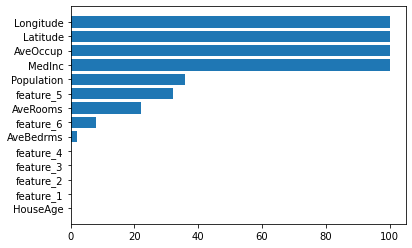

In [48]:
from tqdm import tqdm
from sklearn.feature_selection import RFE

## Defining the input and target variables
X = train.drop(columns = ['id', 'MedHouseVal'], axis = 1)
Y = train['MedHouseVal']

## Defining empty list to store results
lightgbm_support= list()

## Repeating steps 50 times:
for i in tqdm(range(0, 50)):
    
    ## Splitting the data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
    
    ## Runing RFE (recursive feature elimination) with LightGBM as the base algorithm 
    ## (with n_features_to_select = 5)
    lightgbm_rfe = RFE(estimator = LGBMRegressor(), n_features_to_select = 5).fit(X_train, Y_train)
    
    ## Appending the features to be selected
    lightgbm_support.append(lightgbm_rfe.support_)
        
lightgbm_support = pd.DataFrame(lightgbm_support, columns = X.columns)
lightgbm_support = 100 * lightgbm_support.apply(np.sum, axis = 0) / lightgbm_support.shape[0]
lightgbm_support = lightgbm_support.sort_values(ascending = True)


plt.barh(lightgbm_support.index, lightgbm_support.values)
plt.xlabel('Feature Selection Percentage')
plt.title('LightGBM');


In [15]:
X = train.drop(columns = ['id', 'MedHouseVal'], axis = 1)
Y = train['MedHouseVal']

scaler = MinMaxScaler()

## Defining list to store results
lgb_results = list()

for i in range(0, 5):
    
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)
    
    ## Defining list to store fold results
    lgb_fold_result = list()
    
    for train_ix, test_ix in kfold.split(X, Y):
    
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
        
#         ## Scaling the data
#         X_train = scaler.fit_transform(X_train)
#         X_test = scaler.fit_transform(X_test)
        
        ## Building the model 
        lgb_md = LGBMRegressor(n_estimators = 2000, 
                               learning_rate = 0.01,
                               num_leaves = 40,
                               max_depth = 15, 
                               lambda_l1 = 3, 
                               lambda_l2 = 1, 
                               bagging_fraction = 0.7, 
                               feature_fraction = 0.6).fit(X_train, Y_train)

        ## Predicting on test
        lgb_pred = lgb_md.predict(X_test)
        
        ## Appending fold performance
        lgb_fold_result.append(mean_squared_error(Y_test, lgb_pred))
                               
    ## Appending average mse k-fold run 
    lgb_results.append(np.mean(lgb_fold_result))
    
print('The average mse of LightGBM over 5-fold CV (running 5 times) is', np.mean(lgb_results))

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] 

In [19]:
np.sqrt(0.31821170871966054)

0.5641025693255266

In [31]:
np.sqrt(0.31779048138350446)

0.5637290850962938

In [38]:
np.sqrt(0.31726912650632005)

0.5632664791253958

In [49]:
np.sqrt(0.4821169229420178)

0.6943463998192961

In [7]:
np.sqrt(0.31424833493274246)

0.5605785715961167

In [10]:
np.sqrt(0.31381659644285764)

0.5601933563001775

In [11]:
X = train.drop(columns = ['id', 'MedHouseVal'], axis = 1)
Y = train['MedHouseVal']

X_test = test.drop(columns = 'id', axis = 1) 


## Building the lightgbm model
lbg_md = LGBMRegressor(n_estimators = 2000, 
                       learning_rate = 0.01,
                       num_leaves = 40,
                       max_depth = 15, 
                       lambda_l1 = 3, 
                       lambda_l2 = 1, 
                       bagging_fraction = 0.7, 
                       feature_fraction = 0.6).fit(X, Y)

## Predicting 
submission['MedHouseVal'] = lbg_md.predict(X_test)
submission.head()

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7


,id,MedHouseVal
0,37137,0.649182
1,37138,1.064648
2,37139,4.182856
3,37140,3.239107
4,37141,2.551390


In [12]:
submission.to_csv('lgb_submission_2000_FE_0.560193.csv', index = False)

# HistGradientBoosting

In [ ]:
X = train.drop(columns = ['id', 'MedHouseVal'], axis = 1)
Y = train['MedHouseVal']

scaler = MinMaxScaler()

## Defining list to store results
lgb_results = list()

for i in range(0, 5):
    
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)
    
    ## Defining list to store fold results
    lgb_fold_result = list()
    
    for train_ix, test_ix in kfold.split(X, Y):
    
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building the model 
        lgb_md = HistGradientBoostingRegressor()
        lgb_md = LGBMRegressor(n_estimators = 2000, 
                               learning_rate = 0.01,
                               num_leaves = 40,
                               max_depth = 15, 
                               lambda_l1 = 3, 
                               lambda_l2 = 1, 
                               bagging_fraction = 0.7, 
                               feature_fraction = 0.6).fit(X_train, Y_train)

        ## Predicting on test
        lgb_pred = lgb_md.predict(X_test)
        
        ## Appending fold performance
        lgb_fold_result.append(mean_squared_error(Y_test, lgb_pred))
                               
    ## Appending average mse k-fold run 
    lgb_results.append(np.mean(lgb_fold_result))
    
print('The average mse of LightGBM over 5-fold CV (running 5 times) is', np.mean(lgb_results))